<a href="https://colab.research.google.com/github/vivekvj18/ML-PROJECT-2/blob/main/ML_2(Logistic_80_44).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 1 — Imports + Load Dataset

import time
start_all = time.time()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from scipy.stats import zscore

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 200)

# Load dataset
df = pd.read_csv("covtype.csv")   # change path if needed
print("Loaded dataset shape:", df.shape)
df.head()


Loaded dataset shape: (170217, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,2590,56,2,212,-6,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2804,139,9,268,65,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,2785,155,18,242,118,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,2595,45,2,153,-1,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [ ]:
# CELL 2 — Identify continuous, binary, and target columns

continuous_cols = [
    'Elevation','Aspect','Slope',
    'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

target_col = 'Cover_Type'  # standard name in UCI dataset

feature_cols = [c for c in df.columns if c != target_col]
binary_cols = [c for c in feature_cols if c not in continuous_cols]

print("Total Features:", len(feature_cols))
print("Continuous Features:", continuous_cols)
print("Binary/One-Hot Features:", len(binary_cols))
print("\nTarget Distribution:")
print(df[target_col].value_counts().sort_index())


Total Features: 54
Continuous Features: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
Binary/One-Hot Features: 44

Target Distribution:
Cover_Type
1.0     40054
2.0    118453
3.0      2160
4.0      2160
5.0      3069
6.0      2160
7.0      2160
Name: count, dtype: int64


Total missing values: 50


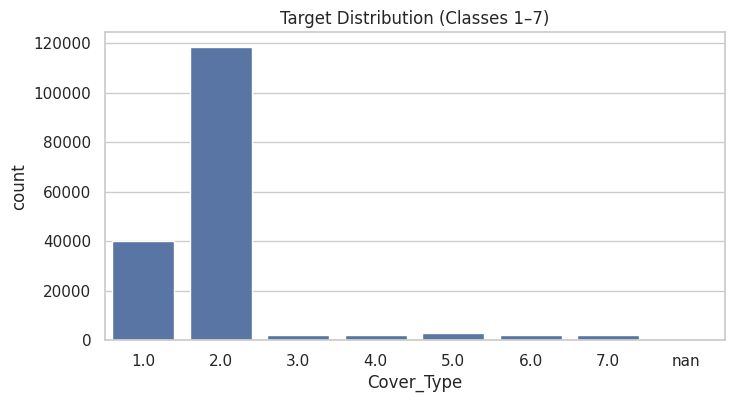

In [ ]:
# CELL 3 — Missing Values + Target Distribution Plot

print("Total missing values:", df.isnull().sum().sum())

plt.figure(figsize=(8,4))
sns.countplot(x=target_col, data=df, order=sorted(df[target_col].unique()))
plt.title("Target Distribution (Classes 1–7)")
plt.show()


,count,mean,std,min,25%,50%,75%,max
Elevation,170217.0,2891.716485,206.673096,1863.0,2767.0,2924.0,3018.00,3849.0
Aspect,170217.0,140.501066,108.301909,0.0,54.0,107.0,221.00,360.0
Slope,170217.0,11.764166,6.203021,0.0,7.0,11.0,15.00,61.0
Horizontal_Distance_To_Hydrology,170217.0,251.216447,192.075259,0.0,95.0,212.0,361.00,1343.0
Vertical_Distance_To_Hydrology,170217.0,34.075339,40.710620,-146.0,6.0,23.0,50.00,554.0
Horizontal_Distance_To_Roadways,170216.0,3386.745917,1690.893761,0.0,1930.0,3503.0,4779.00,7117.0
Hillshade_9am,170216.0,217.274792,21.311859,0.0,207.0,222.0,232.00,254.0
Hillshade_Noon,170216.0,225.000822,15.849606,96.0,216.0,227.0,236.00,254.0
Hillshade_3pm,170216.0,140.178785,31.183767,0.0,121.0,140.0,159.00,248.0
Horizontal_Distance_To_Fire_Points,170216.0,2903.281689,1685.619455,0.0,1620.0,2521.0,4145.25,7173.0


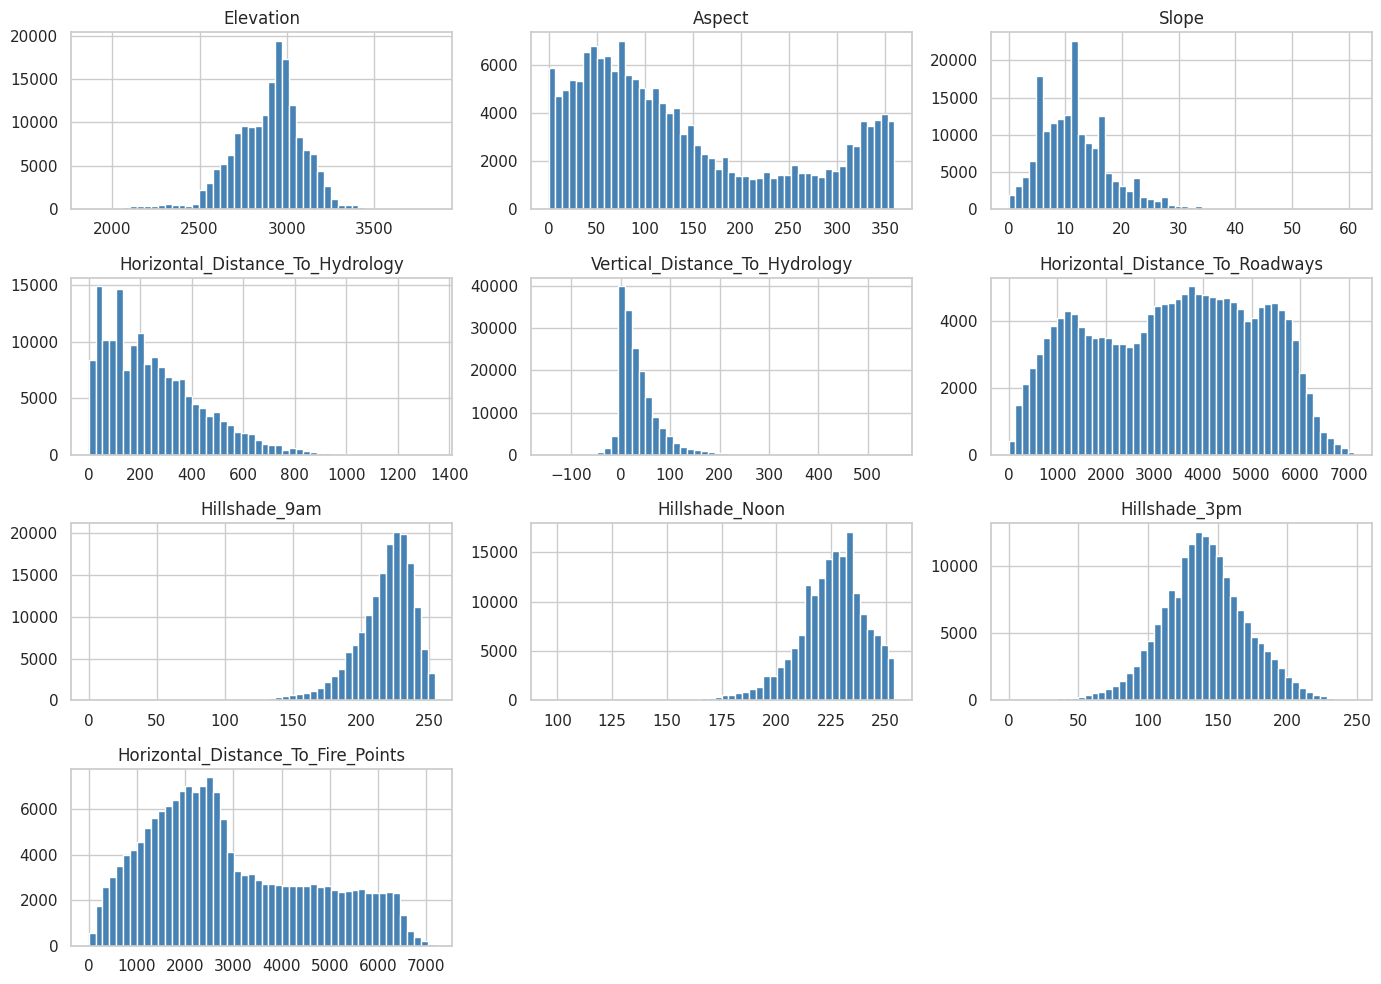

In [ ]:
# CELL 4 — Summary Statistics + Histograms for Continuous Features

display(df[continuous_cols].describe().T)

plt.figure(figsize=(14,10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(4,3,i)
    plt.hist(df[col], bins=50, color='steelblue')
    plt.title(col)
plt.tight_layout()
plt.show()


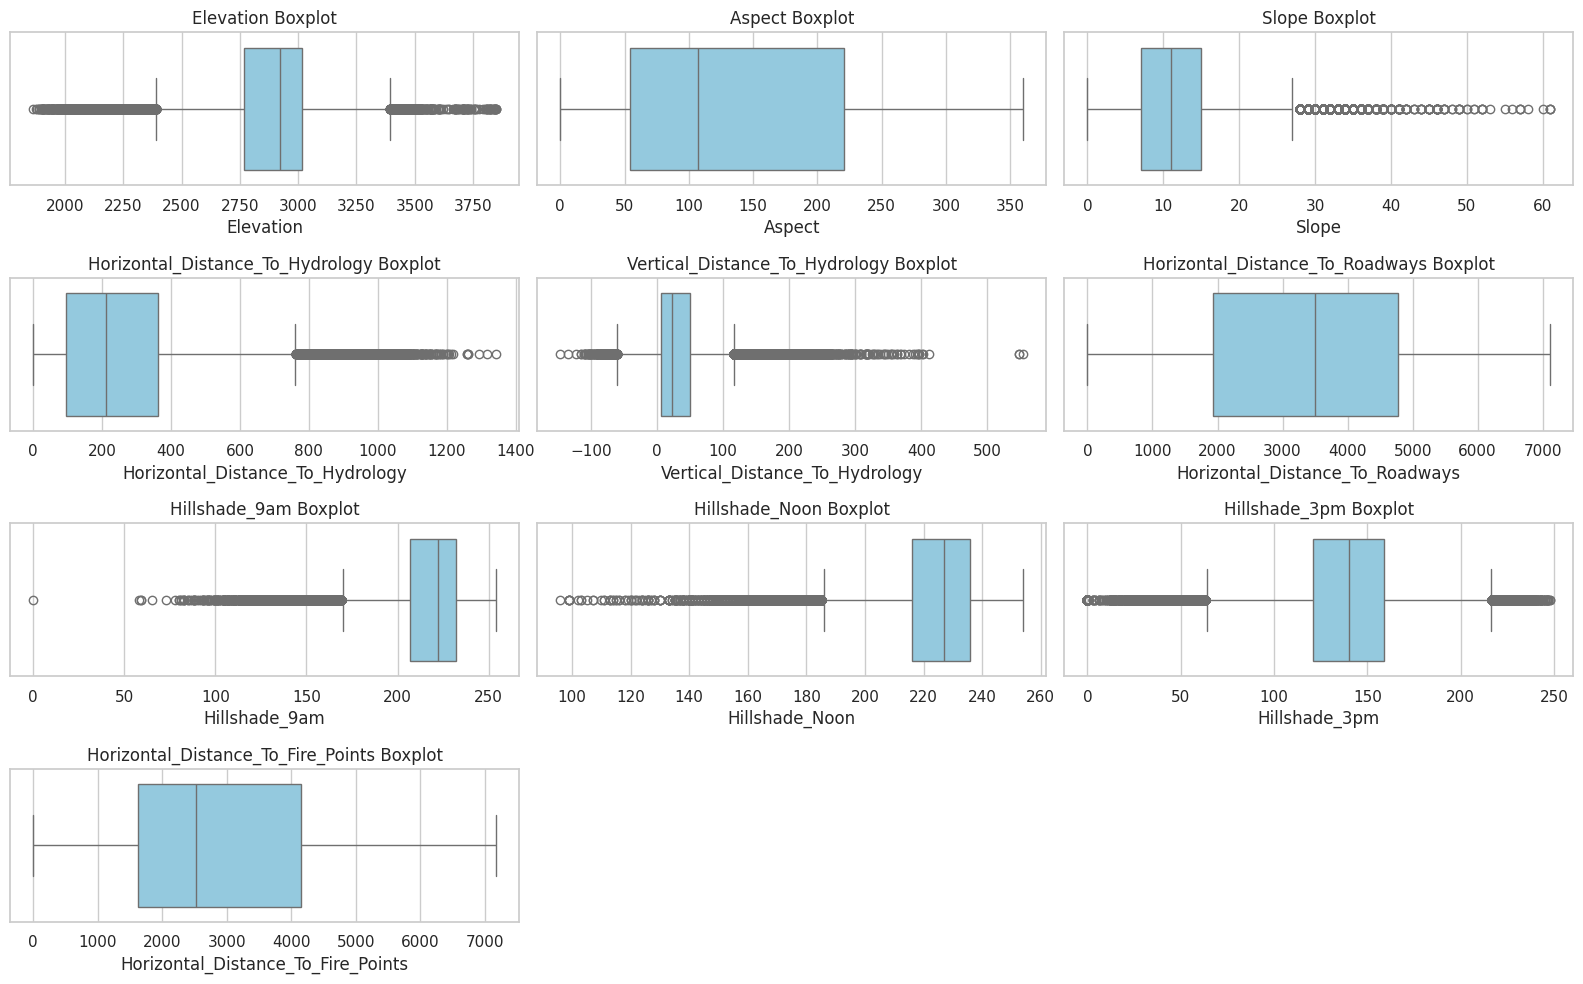

Outlier Counts (Z > |3|):
Vertical_Distance_To_Hydrology        3370
Elevation                             2459
Slope                                 1740
Horizontal_Distance_To_Hydrology      1528
Aspect                                   0
Horizontal_Distance_To_Roadways          0
Hillshade_9am                            0
Hillshade_Noon                           0
Hillshade_3pm                            0
Horizontal_Distance_To_Fire_Points       0
dtype: int64

Total Outlier Points: 9097

NOTE for Report:
Outliers represent natural geographic variation; therefore, we DO NOT remove them.


In [ ]:
# CELL 5 — Boxplots + Z-score Outlier Counts

# Boxplots
plt.figure(figsize=(16,10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(4,3,i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"{col} Boxplot")
plt.tight_layout()
plt.show()

# Z-score outliers
df_z = df[continuous_cols].apply(zscore)
outlier_counts = (np.abs(df_z) > 3).sum().sort_values(ascending=False)
print("Outlier Counts (Z > |3|):")
print(outlier_counts)

print("\nTotal Outlier Points:", int((np.abs(df_z) > 3).sum().sum()))

print("\nNOTE for Report:")
print("Outliers represent natural geographic variation; therefore, we DO NOT remove them.")


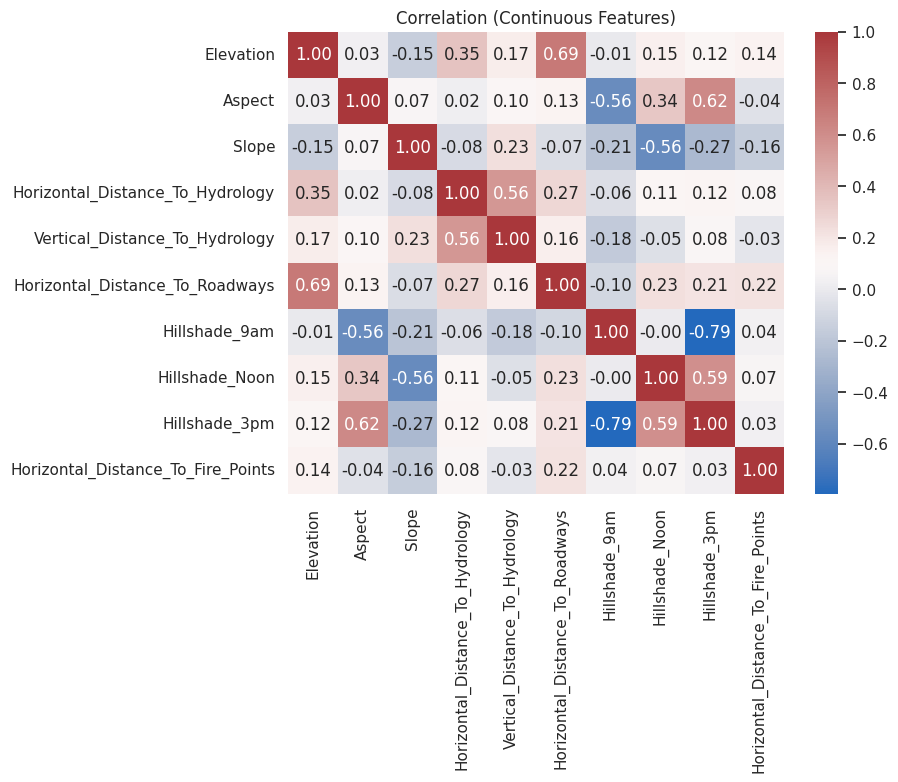

In [ ]:
# CELL 6 — Continuous Feature Correlation Heatmap

plt.figure(figsize=(8,6))
sns.heatmap(df[continuous_cols].corr(), annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation (Continuous Features)")
plt.show()


/tmp/ipython-input-2747077550.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby(target_col, group_keys=False).apply(


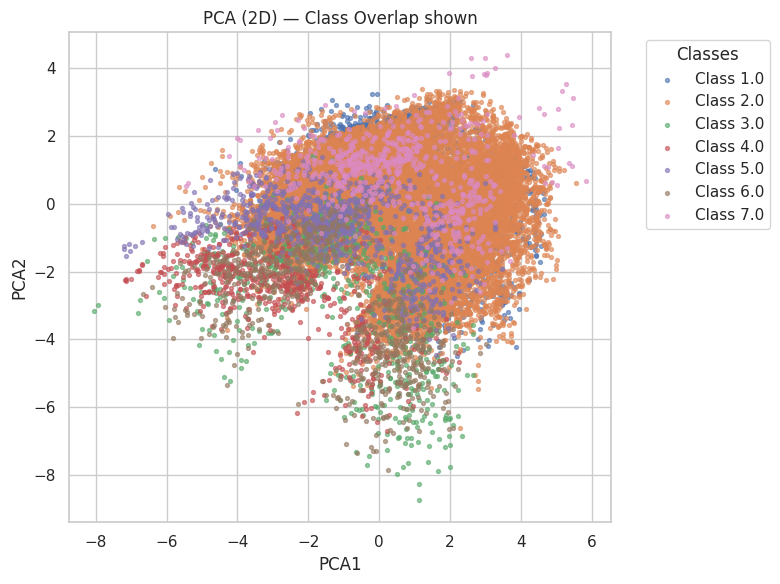

In [ ]:
# CELL 7 — PCA (2D) on Stratified Sample of 50k rows

sample_size = 50000
df_sample = df.groupby(target_col, group_keys=False).apply(
    lambda x: x.sample(int(sample_size * len(x) / len(df)), random_state=42)
).reset_index(drop=True)

X_sample = df_sample[feature_cols]

# scale continuous for PCA
scaler = StandardScaler()
X_cont_scaled = scaler.fit_transform(X_sample[continuous_cols])

# combine scaled continuous + binary numeric
X_pca_input = np.hstack([X_cont_scaled, X_sample[binary_cols].values])

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_pca_input)

plt.figure(figsize=(8,6))
palette = sns.color_palette("tab10", 7)

for cls in sorted(df_sample[target_col].unique()):
    idx = df_sample[target_col] == cls
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=8, alpha=0.6, label=f"Class {cls}")

plt.legend(bbox_to_anchor=(1.05,1), title="Classes")
plt.title("PCA (2D) — Class Overlap shown")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.tight_layout()
plt.show()


In [ ]:
# CORRECTED CELL 8 — Safe Train-Test Split + Preprocessing

print("Original shape:", df.shape)

# 1) Remove rows where target is NaN
nan_target = df[target_col].isnull().sum()
print("NaN in target column:", nan_target)

if nan_target > 0:
    df = df.dropna(subset=[target_col]).reset_index(drop=True)
    print(f"Dropped {nan_target} rows with NaN target.")
else:
    print("No NaN in target. Proceeding.")

# 2) Replace inf → NaN → drop
df = df.replace([np.inf, -np.inf], np.nan)
nan_features = df.isnull().sum().sum() - df[target_col].isnull().sum()

if nan_features > 0:
    print(f"Found {nan_features} NaN in features. Dropping affected rows.")
    df = df.dropna().reset_index(drop=True)
else:
    print("No NaN or inf in features.")

print("Shape after cleaning:", df.shape)

# 3) Final X, y
X = df[feature_cols]
y = df[target_col]

# 4) Safe Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

# 5) Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_cols)
    ],
    remainder='passthrough'
)

print("\nPreprocessor created successfully.")


Original shape: (170217, 55)
NaN in target column: 1
Dropped 1 rows with NaN target.
No NaN or inf in features.
Shape after cleaning: (170216, 55)
Train Shape: (136172, 54)
Test Shape: (34044, 54)

Preprocessor created successfully.


In [ ]:
# CELL 9 — Logistic Regression Baseline (Multinomial LBFGS)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=2000,
        random_state=42,
        n_jobs=-1
    ))
])

t0 = time.time()
pipeline.fit(X_train, y_train)
t1 = time.time()

print(f"Training Time: {t1 - t0:.1f} seconds")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Time: 22.6 seconds


=== LOGISTIC BASELINE RESULTS ===
Test Accuracy : 0.8044295617436259
Macro F1 Score: 0.6893919988066776

Classification Report:
              precision    recall  f1-score   support

         1.0     0.7205    0.4544    0.5573      8011
         2.0     0.8253    0.9404    0.8791     23691
         3.0     0.6469    0.5810    0.6122       432
         4.0     0.8319    0.8935    0.8616       432
         5.0     0.6514    0.3013    0.4120       614
         6.0     0.6190    0.6620    0.6398       432
         7.0     0.9018    0.8287    0.8637       432

    accuracy                         0.8044     34044
   macro avg     0.7424    0.6659    0.6894     34044
weighted avg     0.7937    0.8044    0.7881     34044



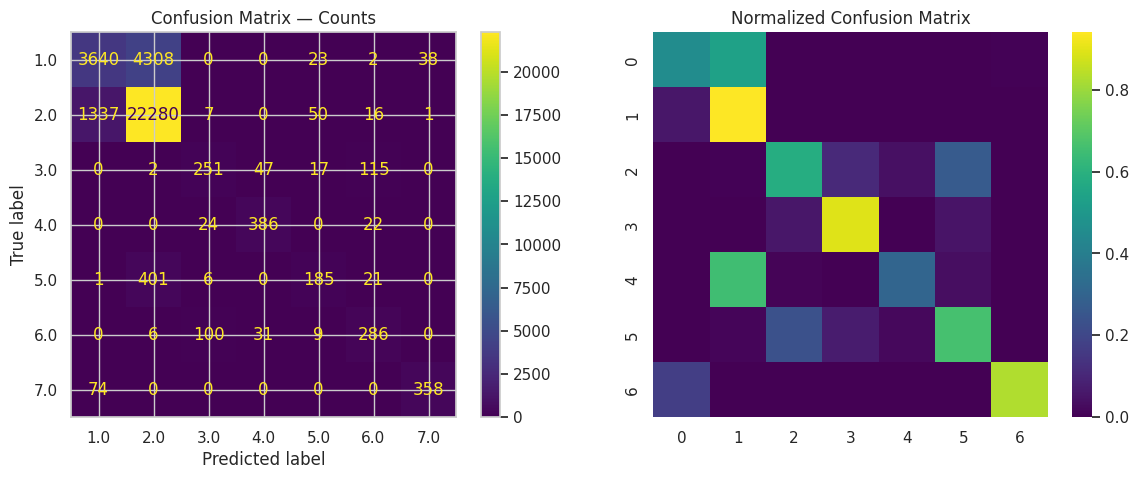

In [ ]:
# CELL 10 — Evaluation Metrics + Confusion Matrix

y_pred = pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

print("=== LOGISTIC BASELINE RESULTS ===")
print("Test Accuracy :", acc)
print("Macro F1 Score:", f1_macro)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix (counts + normalized)
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1,2, figsize=(14,5))

# counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(ax=ax[0], cmap='viridis', values_format='d')
ax[0].set_title("Confusion Matrix — Counts")

# normalized
sns.heatmap(cm / cm.sum(axis=1, keepdims=True), cmap='viridis', ax=ax[1])
ax[1].set_title("Normalized Confusion Matrix")
plt.show()


In [ ]:
# CELL 11 — Cross Validation: STRATIFIED 5-FOLD

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    pipeline, X_train, y_train,
    cv=cv, scoring='f1_macro', n_jobs=-1
)

print("5-Fold CV Scores:", np.round(cv_scores, 4))
print("Mean Macro-F1  :", np.round(cv_scores.mean(), 4))


5-Fold CV Scores: [0.684  0.668  0.6854 0.6846 0.6777]
Mean Macro-F1  : 0.6799


In [ ]:
# CELL 12 — SAVE MODEL & REPORT TEMPLATE

joblib.dump(pipeline, "logreg_baseline_pipeline.pkl")

out_df = X_test.copy()
out_df['y_true'] = y_test
out_df['y_pred'] = y_pred
out_df.to_csv("logreg_baseline_predictions.csv", index=False)

summary = {
    "model": ["Logistic_Baseline"],
    "test_accuracy": [acc],
    "test_macro_f1": [f1_macro],
    "cv_macro_f1_mean": [cv_scores.mean()]
}
pd.DataFrame(summary).to_csv("logreg_baseline_summary.csv", index=False)

print("\n=== REPORT TEMPLATE ===\n")
print(f"""
Baseline Model: Logistic Regression (multinomial, solver=lbfgs)
Scaling: StandardScaler applied to 10 continuous features; 44 binary features untouched.
Results:
    • Accuracy = {acc:.4f}
    • Macro-F1 = {f1_macro:.4f}
    • 5-Fold CV Macro-F1 = {cv_scores.mean():.4f}

Observations:
    • PCA shows strong class overlap → dataset is non-linear.
    • Outliers represent natural terrain variation → not removed.
    • Next: Linear SVM (full data), then RBF-SVM (sampled), then Neural Network.
""")



=== REPORT TEMPLATE ===


Baseline Model: Logistic Regression (multinomial, solver=lbfgs)
Scaling: StandardScaler applied to 10 continuous features; 44 binary features untouched.
Results:
    • Accuracy = 0.8044
    • Macro-F1 = 0.6894
    • 5-Fold CV Macro-F1 = 0.6799

Observations:
    • PCA shows strong class overlap → dataset is non-linear.
    • Outliers represent natural terrain variation → not removed.
    • Next: Linear SVM (full data), then RBF-SVM (sampled), then Neural Network.

